In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 60598152.87it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


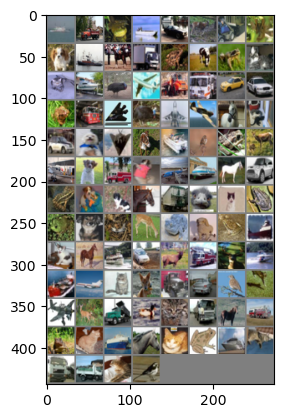

ship  truck frog  ship  car   deer  truck deer  dog   ship  horse truck frog  horse frog  cat   cat   ship  bird  plane truck truck car   car   frog  truck plane bird  plane plane horse cat   car   dog   plane dog   ship  bird  frog  deer  plane dog   truck dog   plane plane horse car   frog  dog   dog   horse truck bird  cat   frog  frog  dog   cat   deer  frog  dog   frog  ship  cat   horse ship  car   deer  truck deer  ship  ship  plane cat   dog   truck car   bird  cat   plane deer  truck bird  cat   truck horse truck frog  cat   ship  horse cat   frog  ship  cat   truck truck cat   bird 


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
images.shape

torch.Size([100, 3, 32, 32])

# Define Utilities

In [107]:
from utils.model import patch_to_image
from utils.general import make_patches
import time
def soft_thresholding(x, gamma):
    return torch.sign(x) * torch.max(torch.abs(x) - gamma, torch.zeros_like(x))


def conjugate_gradient(A, b, x=None, tol=1e-5, max_iterations=200):
    if x is None:
        x = torch.zeros_like(b)
    
    r = b - torch.matmul(A, x)
    p = r.clone()
    rs_old = r.transpose(-1,-2) @ r#torch.dot(r, r)
    
    for i in range(max_iterations):
        Ap = torch.matmul(A, p)
        alpha = rs_old / (p.transpose(-1,-2) @ Ap+1e-10)#torch.dot(p, Ap)
        x += alpha * p
        r -= alpha * Ap
        rs_new = r.transpose(-1,-2) @ r#torch.dot(r, r)
        
        if (torch.sqrt(rs_new) < tol).all():
            break
        
        p = r + (rs_new / (rs_old+1e-10)) * p
        rs_old = rs_new
    # print(i, rs_new)
    return x

def ISTA(img, C, lr, gamma=1, n_steps=100, spa=None):
    # initialize x
    #x = torch.zeros((1,3,4,300,1))
    x = C.transpose(-1,-2) @ img
    loss_list = []
    for i in range(n_steps):
        x = x+lr * C.transpose(-1,-2) @ (img-C @ x)
        x = soft_thresholding(x, gamma*lr)
        loss = torch.norm(img - C @ x).item()+gamma * torch.norm(x,1).item()
        loss_list.append(loss)
    return x, C @ x, loss_list


def FISTA(img, C, lr, gamma=1, n_steps=100, spa=None):
    z = C.transpose(-1,-2) @ img
    loss_list = []
    tk = 1
    x_1 = z
    for i in range(n_steps):
        x = z+lr * C.transpose(-1,-2) @ (img-C @ z)
        x = soft_thresholding(x, gamma*lr)
        
        tk_1 = (1+(1+4 * tk**2)**0.5)/2
        z = x + (tk - 1) / tk_1 * (x - x_1)
        x_1 = x
        tk = tk_1
        
        loss = torch.norm(img - C @ x).item()+gamma * torch.norm(x,1).item()
        loss_list.append(loss)
    return x, C @ x, loss_list

def MM(img, C, gamma=1, n_steps=10):
    x = C.transpose(-1,-2) @ img
    loss_list = []
    Cy = x.clone()
    I = torch.eye(C.shape[-2]).unsqueeze(0).unsqueeze(0)
    for i in range(n_steps):
        W_inv = torch.div(torch.abs(x), gamma)
        D = I + (C * W_inv.transpose(-1,-2)) @ C.transpose(-1,-2)
        v = C * W_inv.transpose(-1,-2) @ Cy
        x = W_inv * Cy - W_inv * C.transpose(-1,-2) @ conjugate_gradient(D, v)
        #x = W_inv * Cy - (W_inv.transpose(-1,-2) * C).transpose(-1,-2) @ \
        #        torch.inverse(I+(C * W_inv.transpose(-1,-2)) @ C.transpose(-1,-2)) @ \
        #                ((C * W_inv.transpose(-1,-2)) @ Cy)
        # print(x_k.min(), x_k.max())
        # normalize & shresholding
        x_index = x / torch.norm(x)
        x_index = torch.abs(x_index) < 1e-3
        x[x_index] = 0
        loss = torch.norm(img - C @ x).item()+gamma * torch.norm(x,1).item()
        loss_list.append(loss)
    return x, C @ x, loss_list

def Adam(img, C, gamma, max_iter=20, tol=1e-6, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    Adam algorithm.

    Args:
    x0: Initial point.
    mu: Regularization parameter.
    max_iter: Maximum number of iterations.
    tol: Tolerance.
    beta1: Decay rate.
    beta2: Decay rate.
    epsilon: Small constant.

    Returns:
    Optimal point.
    """
    x = torch.rand_like(C.transpose(-1,-2) @ img)
    #x = C.transpose(-1,-2) @ img
    m = torch.zeros_like(x)
    v = torch.zeros_like(x)
    loss_list = []
    for t in range(1, max_iter + 1):
        grad = C.transpose(-1,-2) @ (C @ x - img) + gamma * torch.sign(x)
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * grad ** 2
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        x = x - alpha * m_hat / (torch.sqrt(v_hat) + epsilon)
        x_index = x / torch.norm(x)
        x_index = torch.abs(x_index) < 1e-3
        x[x_index] = 0
        loss = torch.norm(img - C @ x).item()+gamma * torch.norm(x,1).item()
        loss_list.append(loss)
        if loss < tol:
            break
    return x, C @ x, loss_list

In [108]:
C = torch.randn(1, 3, 4, 256, 300)
C = C / C.norm(dim=-2, keepdim=True)

x_ISTA, recon_ISTA, loss_ISTA = ISTA(make_patches(images,16), C, 1e-1, 0.3, 20)
x_FISTA, recon_FISTA, loss_FISTA = FISTA(make_patches(images,16), C, 1e-1, 0.3, 20)
x_mm, recon_mm, loss_mm = MM(make_patches(images,16), C, 0.3, 20)
x_adam, recon_adam, loss_adam = Adam(make_patches(images,16), C, gamma=1e-1, max_iter=20)

In [109]:
# get sparsity level
print(torch.sum(torch.abs(x_ISTA) == 0).item() / x_ISTA.numel())
print(torch.sum(torch.abs(x_FISTA) == 0).item() / x_FISTA.numel())
print(torch.sum(torch.abs(x_mm) == 0).item() / x_mm.numel())
print(torch.sum(torch.abs(x_adam) == 0).item() / x_adam.numel())

0.5818138888888889
0.6664916666666667
0.7976694444444444
0.3494027777777778


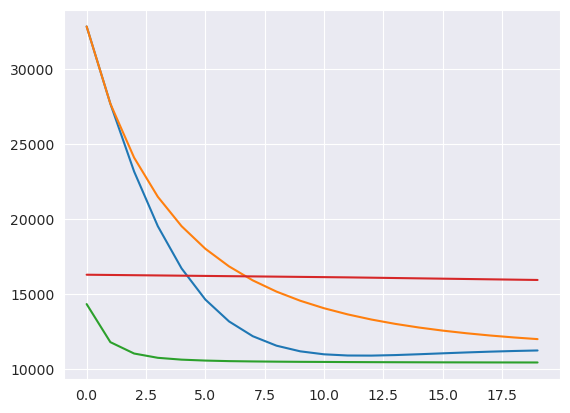

In [110]:
plt.plot(loss_FISTA)
plt.plot(loss_ISTA)
plt.plot(loss_mm)
plt.plot(loss_adam)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


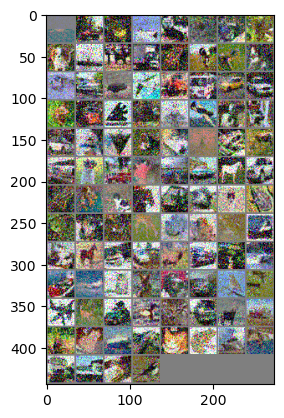

In [93]:
recon_img = patch_to_image(recon_adam, 16)

imshow(torchvision.utils.make_grid(recon_img))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


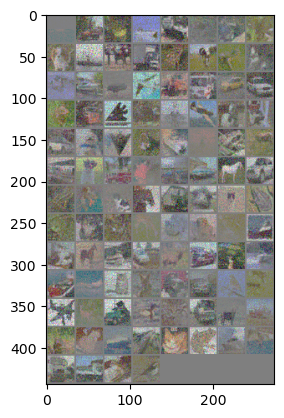

In [62]:
recon_img = patch_to_image(recon_ISTA, 16)

imshow(torchvision.utils.make_grid(recon_img))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


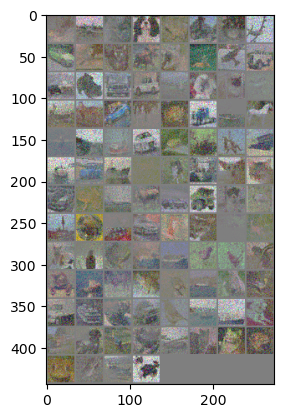

In [10]:
recon_img = patch_to_image(recon_FISTA, 16)

imshow(torchvision.utils.make_grid(recon_img))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


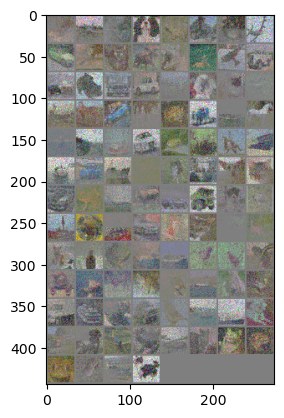

In [11]:
recon_img = patch_to_image(recon_mm, 16)

imshow(torchvision.utils.make_grid(recon_img))

In [111]:
# loop through the entire dataset and record the statistics

loss_all = {'ISTA':[], 'FISTA':[], 'MM':[], 'Adam':[]}
spa_all = {'ISTA':[], 'FISTA':[], 'MM':[], 'Adam':[]}

loss_vis_all = {'ISTA':[], 'FISTA':[], 'MM':[], 'Adam':[]}

for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    x_ISTA, recon_ISTA, loss_ISTA = ISTA(make_patches(inputs,16), C, 1e-2, 0.3, 20)
    x_FISTA, recon_FISTA, loss_FISTA = FISTA(make_patches(inputs, 16), C, 1e-2, 0.3, 20)
    x_mm, recon_mm, loss_mm = MM(make_patches(inputs,16), C, 0.3,20)
    x_adam, recon_adam, loss_adam = Adam(make_patches(images,16), C, gamma=1e-1, max_iter=20)
    
    loss_all['FISTA'].append(loss_FISTA[-1])
    loss_all['ISTA'].append(loss_ISTA[-1])
    loss_all['MM'].append(loss_mm[-1])
    loss_all['Adam'].append(loss_adam[-1])
    
    loss_vis_all['FISTA'].append(np.array(loss_FISTA))
    loss_vis_all['ISTA'].append(np.array(loss_ISTA))
    loss_vis_all['MM'].append(np.array(loss_mm))
    loss_vis_all['Adam'].append(np.array(loss_adam))
    
    spa_FISTA = torch.sum(torch.abs(x_FISTA) == 0).item() / x_FISTA.numel()
    spa_ISTA = torch.sum(torch.abs(x_ISTA) == 0).item() / x_ISTA.numel()
    spa_mm = torch.sum(torch.abs(x_mm) == 0).item() / x_mm.numel()
    spa_adam = torch.sum(torch.abs(x_adam) == 0).item() / x_adam.numel()
    spa_all['FISTA'].append(spa_FISTA)
    spa_all['ISTA'].append(spa_ISTA)
    spa_all['MM'].append(spa_mm)
    spa_all['Adam'].append(spa_adam)
    
    #print(f"Sparsity level ISTA: {spa_ISTA}")
    #print(f"Sparsity level FISTA: {spa_FISTA}")
    #print(f"Sparsity level MM: {spa_mm}")
    
    if (i+1) % 10 == 0:
        print(i+1)
    if i == 9:
        print("done")
        break

10
done


In [112]:
print(np.mean(loss_all['ISTA']), np.std(loss_all['ISTA']))
print(np.mean(loss_all['FISTA']), np.std(loss_all['FISTA']))
print(np.mean(loss_all['MM']), np.std(loss_all['MM']))
print()
print(np.mean(spa_all['ISTA']), np.std(spa_all['ISTA']))
print(np.mean(spa_all['FISTA']), np.std(spa_all['FISTA']))
print(np.mean(spa_all['MM']), np.std(spa_all['MM']))

29559.786843566893 925.7680355649331
17655.814603271487 730.9071230410161
10963.357807006836 540.5837314452708

0.09147777777777777 0.005149936473298708
0.19800416666666665 0.010957275561538162
0.7969933333333332 0.004706811815776779


In [113]:
np.vstack(loss_vis_all['FISTA']).shape

(10, 20)

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

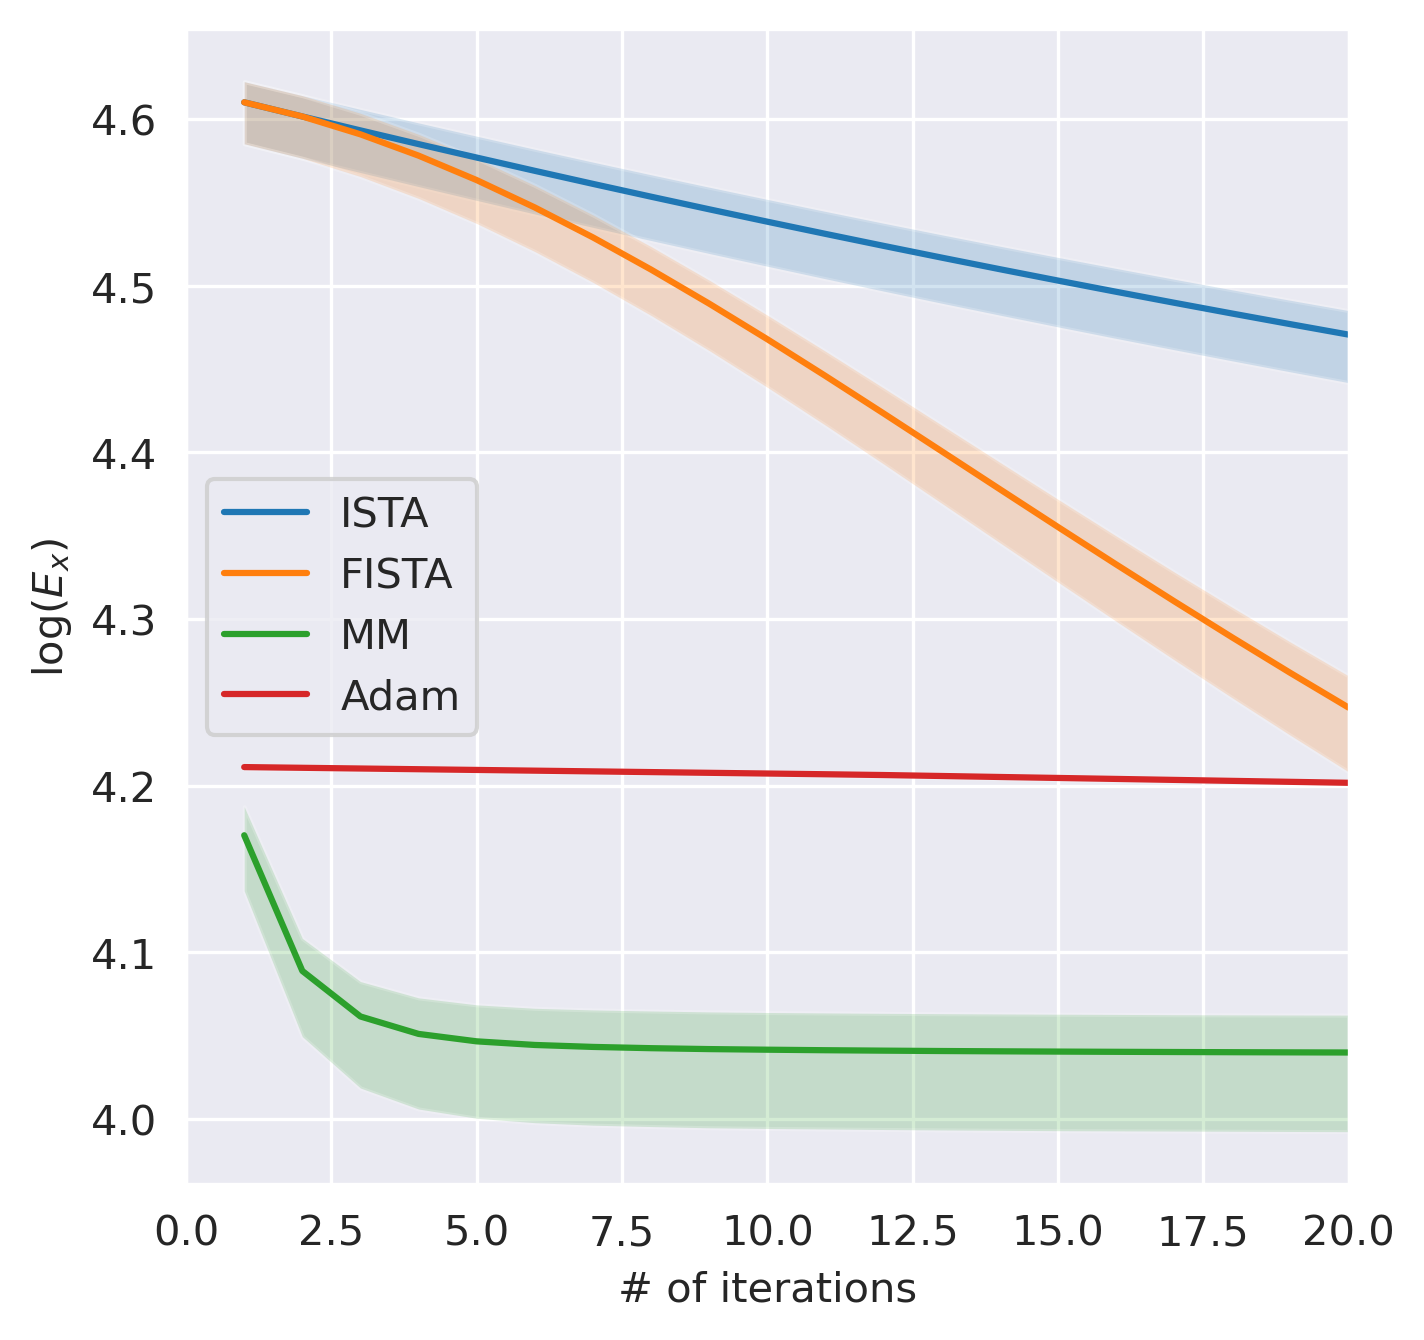

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

In [115]:
import seaborn as sns
#sns.set_theme(style="whitegrid",palette=None)
# use fonts times new romans
plt.rcParams['font.family'] = 'Times New Roman'
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})
sns.set_style("darkgrid")
#sns.set_style("whitegrid")
#sns.lineplot()
x = [i+1 for i in range(20)]
y = np.linspace(6.5, 8.4, 20)
fig, ax = plt.subplots(figsize=(5,5), dpi=300)
x_t = [1,5,10,15,20]
#plt.xticks(x[::4])
#plt.yticks(y[::4])
loss_FISTA = np.vstack(loss_vis_all['FISTA'])
loss_ISTA = np.vstack(loss_vis_all['ISTA'])
loss_MM = np.vstack(loss_vis_all['MM'])
loss_adam = np.vstack(loss_vis_all['Adam'])
ax.plot(x, np.log10(np.mean(loss_ISTA, axis=0)), label='ISTA')#, linestyle='-', marker='o')
ax.fill_between(x, np.log10(loss_ISTA.min(axis=0)), np.log10(loss_ISTA.max(axis=0)), alpha=0.2)
ax.plot(x, np.log10(np.mean(loss_FISTA, axis=0)), label='FISTA')#, linestyle='-', marker='.')
ax.fill_between(x, np.log10(loss_FISTA.min(axis=0)), np.log10(loss_FISTA.max(axis=0)), alpha=0.2)
ax.plot(x, np.log10(np.mean(loss_MM, axis=0)), label='MM')#, linestyle='-', marker='^')
ax.fill_between(x, np.log10(loss_MM.min(axis=0)), np.log10(loss_MM.max(axis=0)), alpha=0.2)
ax.plot(x, np.log10(np.mean(loss_adam, axis=0)), label='Adam')#, linestyle='-', marker='^')
ax.fill_between(x, np.log10(loss_adam.min(axis=0)), np.log10(loss_adam.max(axis=0)), alpha=0.2)
L=ax.legend()
plt.setp(L.texts, family='Times New Roman')



#plt.setp(ax.patches, linewidth=0)
#plt.xlabel='# of iterations'
#plt.ylabel="$log(E_x)"
x_l = ax.set_xlabel('# of iterations')
y_l = ax.set_ylabel("$\log(E_x)$")

ax.set_xlim([0,20])
#ax.set_ylim([6.4,8.4])
#plt.setp(x_l, family='Times New Roman')
plt.setp(y_l, family='Times New Roman')
plt.show()

# save as pdf
fig.savefig('loss.pdf', dpi=300, bbox_inches='tight')
